BEFORE IMBALANCE:  0    35021
1    34979
Name: cardio, dtype: int64
AFTER IMBALANCE:  0    35021
1     6995
Name: cardio, dtype: int64


 TomekLinks + RandomOverSampler + XGBClassifier:
accuracy: 0.7821782178217822
balanced accuracy:  0.737104240687099
weighted f1_score:  0.8012785015363949
roc-auc:  0.794445516553638
precision_recall_auc:  0.4391902551117466
g-mean:  0.7357248114778833
Confusion matrix:
 [[7045 1710]
 [ 578 1171]]


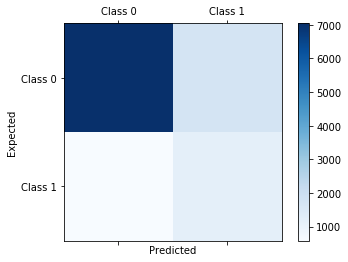

In [1]:
# installations, if not already performed
#!pip install lime
#!pip install eli5
#!pip install shap
#!pip install pdpbox
#!pip install xgboost
#!pip install Ipython

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
import graphviz
import statistics
import collections
import numpy as np
import pandas as pd
import xgboost
from tqdm import tqdm
import seaborn as sns
from numpy import mean
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn import datasets,model_selection
from sklearn.model_selection import KFold, cross_validate, train_test_split
from imblearn.datasets import make_imbalance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from imblearn.metrics import geometric_mean_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, RandomUnderSampler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN, RandomOverSampler
from sklearn.metrics import roc_auc_score, confusion_matrix, make_scorer, precision_recall_curve, auc, \
    balanced_accuracy_score, accuracy_score, precision_recall_fscore_support, f1_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import SVG
from IPython.display import display
from ipywidgets import interactive
from graphviz import Source
from pdpbox import pdp, get_dataset, info_plots # PDP
import lime.lime_tabular # LIME
from lime.explanation import Explanation
import eli5 # ELI5
from eli5.sklearn import PermutationImportance
import shap # SHAP

%matplotlib inline


# ======================================================================================================================

random_state = 27  # define random state for re-producability

# ======================================================================================================================

df = pd.read_csv('cardio_train.csv', sep=";")
df.drop('id', 1, inplace=True)  # delete column 'id'

#print(df.isnull().sum())   # there are no null values
df.replace("", float("NaN"), inplace=True)  # convert empty field to NaN
df.dropna(inplace=True)  # drop NaN rows
df.reset_index(drop=True, inplace=True)

df['age'] = np.floor(df['age'] / 365.25)  # convert age

X = df.iloc[:, :-1]  # .values  # convert to numpy array
y = df.iloc[:, -1]  # .values  # convert to numpy array
# Separate input features and target
#y = df.cardio
#X = df.drop('cardio', axis=1)

#print(X, " and ", y)


# ======================================================================================================================
# VISUALIZE with PCA in 2D Graph
# ======================================================================================================================

def plot_2d_space(X, y, label='Classes'):
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y == l, 0],
            X[y == l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()


# ======================================================================================================================
'''
# Visualize BALANCED DATA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plot_2d_space(X_pca, y, 'Imbalanced dataset (2 PCA components)')
'''


# ======================================================================================================================
# INSERT ACTIVE LEARNING (instead of "Make the dataset IMBALANCED (with random undersampling)" below)
# ======================================================================================================================





# ======================================================================================================================
# Make the dataset IMBALANCED (with random undersampling)
# ======================================================================================================================

# downsample majority

print("BEFORE IMBALANCE: ", y.value_counts())

# keep all samples of class 0 and 1/5 samples of class 1
sampling_strategy = {0: y.value_counts()[0], 1: int(y.value_counts()[1] / 5)}
X, y = make_imbalance(X, y, sampling_strategy=sampling_strategy)

print("AFTER IMBALANCE: ", y.value_counts())


# ======================================================================================================================
'''
# Visualize IMBALANCED DATA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plot_2d_space(X_pca, y, 'Imbalanced dataset (2 PCA components)')
'''

# ======================================================================================================================
# Scale data
# ======================================================================================================================

# Min-Max scaling data
scale_continuous_columns = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']  # continuous features
# categorical_columns = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

t = [('num', MinMaxScaler(), scale_continuous_columns)]
# remainder='passthrough': keeps the non transformed columns
minmax_transformer = ColumnTransformer(transformers=t, remainder='passthrough')  # use it on pipelines

print('\n============================================================================================================')


# ======================================================================================================================
# Set SCORING METRICS for cross_validate
# ======================================================================================================================

def precision_recall_auc_score(y_test_valid, y_positive_class_probs):
    # needs_proba=True from make_scorer keeps only the positive class probabilities
    precision, recall, _ = precision_recall_curve(y_test_valid, y_positive_class_probs)
    auc_score = auc(recall, precision)

    return auc_score


# ======================================================================================================================
# Split to train and test data
# ======================================================================================================================

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=random_state)


# ======================================================================================================================
#  OVERSAMLING
# ======================================================================================================================

# RANDOM OVERSAMLING with replacement
random_over = RandomOverSampler(random_state=random_state)


# ======================================================================================================================
#  UNDERSAMPLING
# ======================================================================================================================

# cut half of the majority class (only for RandomUnderSampler)
under_sampling_strategy = {0: int(y_train.value_counts()[0] / 2), 1: y_train.value_counts()[1]}

# Tomek Links UNDERSAMPLING
tomek = TomekLinks(sampling_strategy='majority')

# RANDOM UNDERSAMPLING
random_under = RandomUnderSampler(sampling_strategy=under_sampling_strategy, random_state=random_state)  # reduce the number of examples in the majority class by 50 percent


# ======================================================================================================================
# CLASSIFIERS
# ======================================================================================================================

# LogisticRegression
clf2 = LogisticRegression(solver="liblinear", C=400, max_iter=300, class_weight="balanced")

# XGBClassifier
# scale_pos_weight: scale the gradient for the positive class, set to inverse of the class distribution (ratio 1:5 -> 5)
xgb_imb_aware = XGBClassifier(learning_rate=0.01, n_estimators=1000, max_depth=4, min_child_weight=6, gamma=0,
                            subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005, objective='binary:logistic',
                            nthread=4, random_state=random_state)


# ======================================================================================================================
# MINMAX scaler for continuous features
# ======================================================================================================================

x_train_scaled = minmax_transformer.fit_transform(x_train, y_train)
x_test_scaled = minmax_transformer.transform(x_test)


# ======================================================================================================================
# TomekLinks + RandomOverSampler + XGBClassifier
# ======================================================================================================================

# UNDER-SAMPLING
# print(y_train.value_counts())
under_x_train, under_y_train = tomek.fit_resample(x_train_scaled, y_train)
# print(under_y_train.value_counts())


# OVER-SAMPLING
majority_class = under_y_train.value_counts()[0]
# over-sample 90% of the new difference of majority and minority labels (new = after under-sampling)
minority_class = under_y_train.value_counts()[1] + 0.80 * (under_y_train.value_counts()[0] - under_y_train.value_counts()[1])
over_sampling_strategy = {0: majority_class,
                          1: int(minority_class)}
random_over.set_params(sampling_strategy=over_sampling_strategy)
under_over_x_train, under_over_y_train = random_over.fit_resample(under_x_train, under_y_train)
# print(under_over_y_train.value_counts())


# set class imbalance parameter
xgb_imb_aware.set_params(scale_pos_weight=int(under_over_y_train.value_counts()[0] / under_over_y_train.value_counts()[1]))

# fit classifier
model_1 = xgb_imb_aware.fit(under_over_x_train, under_over_y_train)
y_pred = xgb_imb_aware.predict(x_test_scaled)
y_pred_proba = xgb_imb_aware.predict_proba(x_test_scaled)[:, 1]  # get only the probabilities for the positive class

print("\n", "TomekLinks + RandomOverSampler + XGBClassifier:")
print("accuracy:", accuracy_score(y_test, y_pred))
print("balanced accuracy: ", balanced_accuracy_score(y_test, y_pred))
print("weighted f1_score: ", f1_score(y_test, y_pred, average='weighted'))
print("roc-auc: ", roc_auc_score(y_test, y_pred_proba))
print("precision_recall_auc: ", precision_recall_auc_score(y_test, y_pred_proba))
print("g-mean: ", geometric_mean_score(y_test, y_pred, average='weighted'))

# ======================================================================================================================
# Confusion Matrix
# ======================================================================================================================

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()



In [2]:

# ======================================================================================================================
# INTERPRETABILITY
# ======================================================================================================================
# ====================================================================================================================== 
# Black Box Model interpretation
# ====================================================================================================================== 
# reuse part of the https://colab.research.google.com/drive/1PuXCVSS4jjK3psMu7pwNCTlsmnIlVQ9T#scrollTo=CzY2OYJN9krH code
# ======================================================================================================================
# Plot Tree Function
# ======================================================================================================================
def plot_tree(depth):
    estimator = DecisionTreeClassifier(random_state = 0,criterion = 'gini', max_depth = depth)
    estimator.fit(new_x_train, new_y_train)
    graph = Source(export_graphviz(estimator, out_file=None, feature_names=feature_names,  class_names=labels, precision=7, filled = True))
    print("Fidelity",accuracy_score(y_pred, estimator.predict(x_test_scaled)))
    print("Accuracy in new data")
    print(accuracy_score(y_test, estimator.predict(x_test_scaled)))
    display(SVG(graph.pipe(format='svg')))
    return estimator

print("Black Box Model")
print("Interpret TomekLinks + RandomOverSampler + XGBClassifier")
i = np.random.randint(0, x_test_scaled.shape[0]) # test for random instance

#under_over_x_train = under_over_x_train.values
#x_test = x_test.values
#under_over_y_train = under_over_y_train.values
y_test = y_test.values

# assign features names
feature_names = df.columns.drop(['cardio'])

numerical_features= ["age", "height", "weight", "ap_hi", "ap_lo"]
# categorical_features = ["gender", "cholesterol", "gluc", "smoke", "alco", "active"]
# if a feature has 5 or less unique values then treat it as categorical
categorical_features = np.argwhere(np.array([len(set(under_over_x_train[:,x])) for x in range(under_over_x_train.shape[1])]) <= 5).flatten()

# Train as a black box with the preselected classifier
classifier= model_1 #classifier assignment

# Train decision tree as white box model to interpret the results 
new_x_train = under_over_x_train
new_y_train = classifier.predict(under_over_x_train)

Black Box Model
Interpret TomekLinks + RandomOverSampler + XGBClassifier


In [3]:
print("Explain with Decision Tree")


Explain with Decision Tree


Fidelity 0.9345963442498096
Accuracy in new data
0.7451447067783702


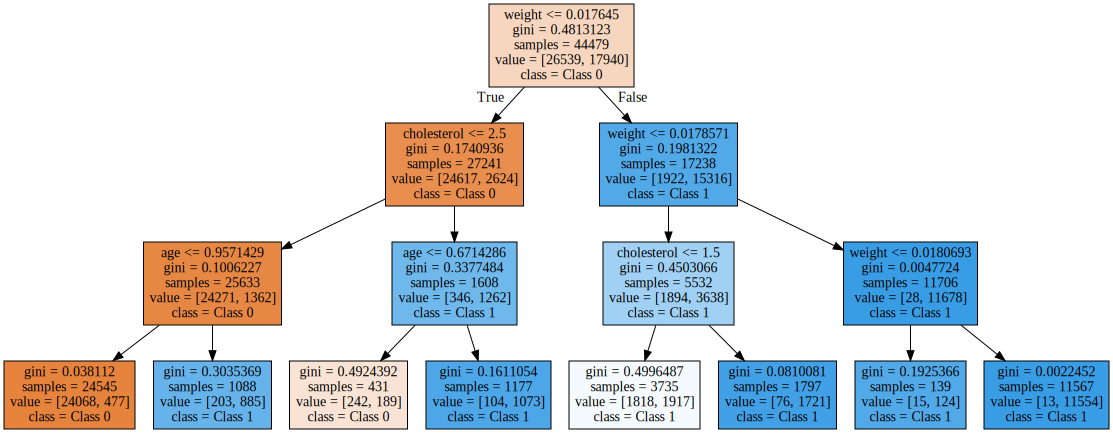

In [4]:
print("Explain with Decision Tree")

plt.figure() 
inter=interactive(plot_tree,depth=(1,5))
display(inter)
plt.show()

In [5]:
# ======================================================================================================================
# Different Approches deployed to check results locally and globally
# ======================================================================================================================

# Local models  
print("LIME Model")
# LIME
explainer = lime.lime_tabular.LimeTabularExplainer(under_over_x_train, feature_names=feature_names, class_names=[0, 1],categorical_features=categorical_features, discretize_continuous=True)
exp = explainer.explain_instance(x_test_scaled[i], classifier.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)
exp.as_pyplot_figure

LIME Model


<bound method Explanation.as_pyplot_figure of <lime.explanation.Explanation object at 0x00000173035AAA90>>

Model Features importance
Feature ranking:
1 weight 0.43494493
2 ap_hi 0.14973438
3 cholesterol 0.14062226
4 age 0.08598838
5 active 0.039661814
6 height 0.034070756
7 gluc 0.027921855
8 smoke 0.02599438
9 alco 0.024552168
10 gender 0.01826062
11 ap_lo 0.018248482


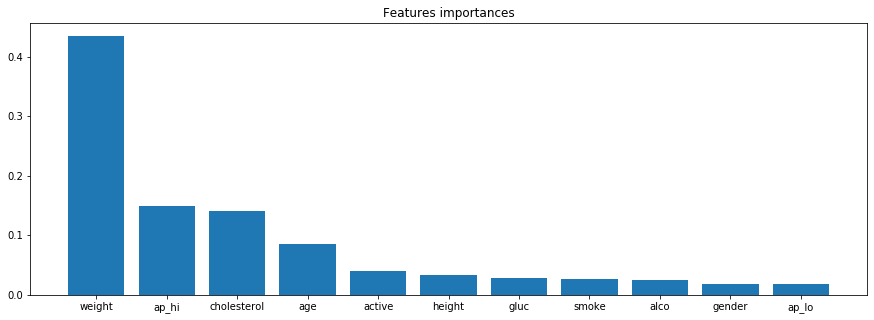

In [6]:
print("Model Features importance")
# features importance 
    
# model built-in features importance
importances = classifier.feature_importances_
# print(importances)
indices = np.argsort(importances)[::-1]
feature_indices = [ind for ind in indices[:len(importances)]]

# Print the feature ranking
print("Feature ranking:")
for f in range(len(importances)):
    print(f+1, feature_names[feature_indices[f]], importances[indices[f]])


plt.figure(figsize=(15,5))
plt.title("Features importances")
bars = plt.bar(range(len(importances)), importances[indices[:len(importances)]], align="center")
ticks = plt.xticks(range(len(importances)),feature_names[feature_indices[:]])
plt.show()

In [7]:
print("ELI5")
# features importance with ELI5
perm = PermutationImportance(classifier).fit(x_test_scaled, y_test)
eli5.show_weights(perm, feature_names = feature_names.tolist())
display(eli5.show_weights(perm, feature_names = feature_names.tolist()))
#eli5.show_prediction(classifier, x_test_scaled[i], show_feature_values=True, feature_names=feature_names.tolist())
#display( eli5.show_prediction(classifier, x_test_scaled[i], show_feature_values=True, feature_names=feature_names.tolist()))


ELI5


Weight,Feature
0.0837 ± 0.0047,weight
0.0258 ± 0.0037,cholesterol
0.0132 ± 0.0041,age
0.0038 ± 0.0009,gluc
0.0008 ± 0.0024,active
0.0005 ± 0.0009,gender
0.0004 ± 0.0016,smoke
0.0003 ± 0.0011,alco
-0.0001 ± 0.0039,height
-0.0002 ± 0.0007,ap_lo


In [8]:
print("SHAP")
# SHAP for evaluating variable importance
data= shap.kmeans(under_over_x_train, 3) 
explainer = shap.KernelExplainer(classifier.predict, data)
shap_values = explainer.shap_values(under_over_x_train, nsamples=100)

# show how each feature contributes to shifting the prediction from the base value to the output value of the model either by decreasing or increasing the probability of our class.
plt.figure() 
shap.force_plot(explainer.expected_value, shap_values[i], x_test_scaled[i], feature_names=feature_names)
#plt.savefig('SHAP_feature_.png', bbox_inches="tight")
plt.show()

SHAP


<Figure size 432x288 with 0 Axes>

In [9]:
shap.force_plot(explainer.expected_value, shap_values[i], x_test_scaled[i], feature_names=feature_names)

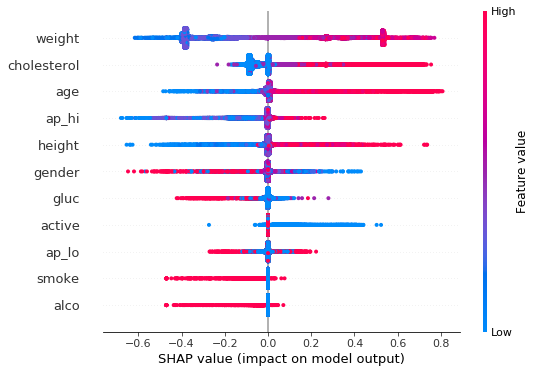

In [10]:
shap.summary_plot(shap_values, under_over_x_train, show=False, feature_names=feature_names)
#plt.savefig('SHAP_Summary_.png', bbox_inches="tight")
plt.show()



 RandomUnderSampler + RandomOverSampler + XGBClassifier:
accuracy: 0.7774181264280274
balanced accuracy:  0.7331048924424138
weighted f1_score:  0.7973646887346708
roc-auc:  0.7925986261546535
precision_recall_auc:  0.43602322911718294
g-mean:  0.7317643887322882
Confusion matrix:
 [[7000 1755]
 [ 583 1166]]


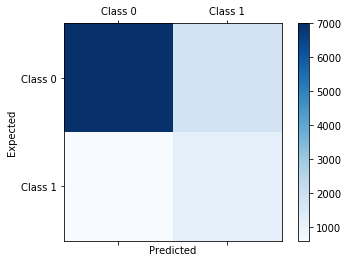

In [13]:
# ======================================================================================================================
# RandomUnderSampler + RandomOverSampler + XGBClassifier
# ======================================================================================================================

# UNDER-SAMPLING
# print(y_train.value_counts())
under_x_train, under_y_train = random_under.fit_resample(x_train_scaled, y_train)
# print(under_y_train.value_counts())


# OVER-SAMPLING
majority_class = under_y_train.value_counts()[0]
# over-sample 90% of the new difference of majority and minority labels (new = after under-sampling)
minority_class = under_y_train.value_counts()[1] + 0.80 * (under_y_train.value_counts()[0] - under_y_train.value_counts()[1])
over_sampling_strategy = {0: majority_class,
                          1: int(minority_class)}
random_over.set_params(sampling_strategy=over_sampling_strategy)
under_over_x_train, under_over_y_train = random_over.fit_resample(under_x_train, under_y_train)
# print(under_over_y_train.value_counts())


# set class imbalance parameter
xgb_imb_aware.set_params(scale_pos_weight=int(under_over_y_train.value_counts()[0] / under_over_y_train.value_counts()[1]))

# fit classifier
model_2 = xgb_imb_aware.fit(under_over_x_train, under_over_y_train)
y_pred = xgb_imb_aware.predict(x_test_scaled)
y_pred_proba = xgb_imb_aware.predict_proba(x_test_scaled)[:, 1]  # get only the probabilities for the positive class

print("\n", "RandomUnderSampler + RandomOverSampler + XGBClassifier:")
print("accuracy:", accuracy_score(y_test, y_pred))
print("balanced accuracy: ", balanced_accuracy_score(y_test, y_pred))
print("weighted f1_score: ", f1_score(y_test, y_pred, average='weighted'))
print("roc-auc: ", roc_auc_score(y_test, y_pred_proba))
print("precision_recall_auc: ", precision_recall_auc_score(y_test, y_pred_proba))
print("g-mean: ", geometric_mean_score(y_test, y_pred, average='weighted'))

# ======================================================================================================================
# Confusion Matrix
# ======================================================================================================================

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()


In [15]:
print("Interpret RandomUnderSampler + RandomOverSampler + XGBClassifier")

# Train as a black box with the preselected classifier
classifier= model_2 #classifier assignment
  
new_x_train = under_over_x_train
new_y_train = classifier.predict(under_over_x_train)

Interpret RandomUnderSampler + RandomOverSampler + XGBClassifier


Fidelity 0.9379284082254379
Accuracy in new data
0.743907083015994


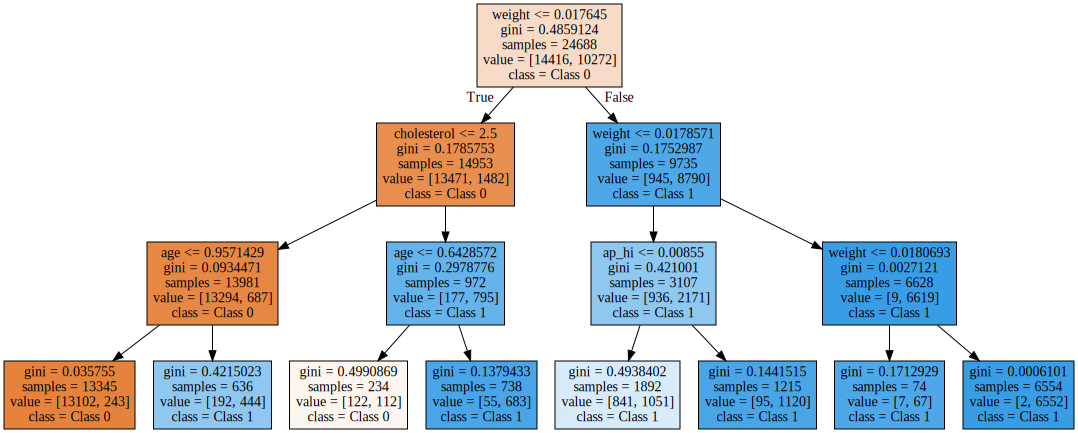

In [16]:
plt.figure() 
print("Explain with Decision Tree")
inter=interactive(plot_tree,depth=(1,5))
display(inter)
    

LIME Model


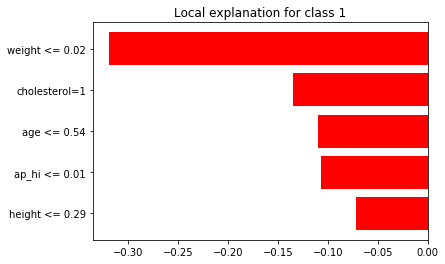

<Figure size 432x288 with 0 Axes>

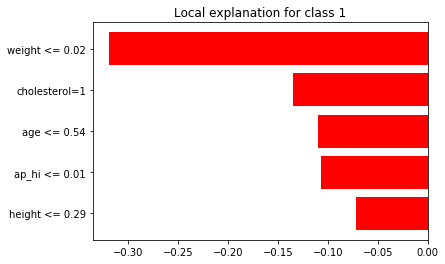

In [19]:
# ======================================================================================================================
# Different Approches deployed to check results locally and gloabally
# ======================================================================================================================

# Local models
print("LIME Model")
# LIME
plt.figure() 
explainer = lime.lime_tabular.LimeTabularExplainer(under_over_x_train, feature_names=feature_names, class_names=[0, 1],categorical_features=categorical_features, discretize_continuous=True)
exp = explainer.explain_instance(x_test_scaled[i], classifier.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)
exp.as_pyplot_figure()


Model Features inmportance
Feature ranking:
1 weight 0.449688
2 cholesterol 0.13527244
3 ap_hi 0.123013824
4 age 0.08527076
5 active 0.037943833
6 height 0.03692175
7 smoke 0.032423995
8 gluc 0.02951684
9 alco 0.02646295
10 ap_lo 0.021959892
11 gender 0.021525735


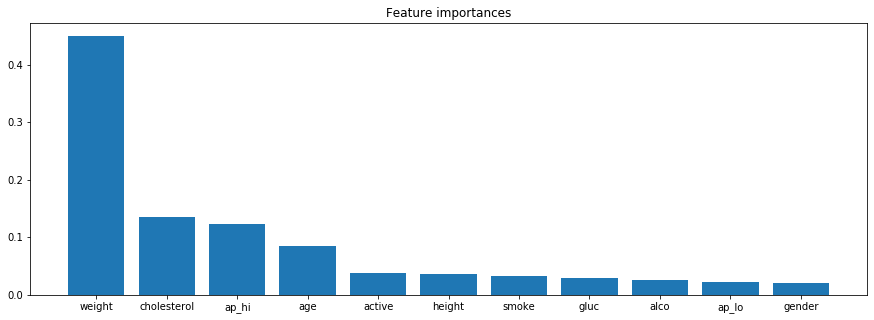

In [20]:
# features importance 

print("Model Features inmportance")
#  model built-in features importance
importances = classifier.feature_importances_
# print(importances)
indices = np.argsort(importances)[::-1]
feature_indices = [ind for ind in indices[:len(importances)]]

# Print the feature ranking
print("Feature ranking:")
for f in range(len(importances)):
    print(f+1, feature_names[feature_indices[f]], importances[indices[f]])

plt.figure(figsize=(15,5))
plt.title("Feature importances")
bars = plt.bar(range(len(importances)), importances[indices[:len(importances)]], align="center")
ticks = plt.xticks(range(len(importances)),feature_names[feature_indices[:]])
plt.show()


In [21]:
print("ELI5")
# features importance with ELI5
perm = PermutationImportance(classifier).fit(x_test_scaled, y_test)
eli5.show_weights(perm, feature_names = feature_names.tolist())
display(eli5.show_weights(perm, feature_names = feature_names.tolist()))
#eli5.show_prediction(classifier, x_test_scaled[i], show_feature_values=True, feature_names=feature_names.tolist())
#display( eli5.show_prediction(classifier, x_test_scaled[i], show_feature_values=True, feature_names=feature_names.tolist()))

ELI5


Weight,Feature
0.0843 ± 0.0088,weight
0.0204 ± 0.0058,cholesterol
0.0101 ± 0.0034,age
0.0029 ± 0.0010,gluc
0.0007 ± 0.0010,active
0.0002 ± 0.0022,height
-0.0003 ± 0.0011,smoke
-0.0004 ± 0.0012,alco
-0.0010 ± 0.0016,gender
-0.0025 ± 0.0024,ap_hi


In [24]:
# SHAP for evaluating variable importance
data= shap.kmeans(under_over_x_train, 3) 
explainer = shap.KernelExplainer(classifier.predict, data)
shap_values = explainer.shap_values(under_over_x_train, nsamples=100)




SHAP


<Figure size 432x288 with 0 Axes>

In [25]:
print("SHAP")
# show how each feature contributes to shifting the prediction from the base value to the output value of the model either by decreasing or increasing the probability of our class.
# plot instance
plt.figure() 
shap.force_plot(explainer.expected_value, shap_values[i], x_test_scaled[i], feature_names=feature_names)
#plt.savefig('SHAP_feature.png', bbox_inches="tight")
plt.show()

SHAP


<Figure size 432x288 with 0 Axes>

In [26]:
shap.force_plot(explainer.expected_value, shap_values[i], x_test_scaled[i], feature_names=feature_names)

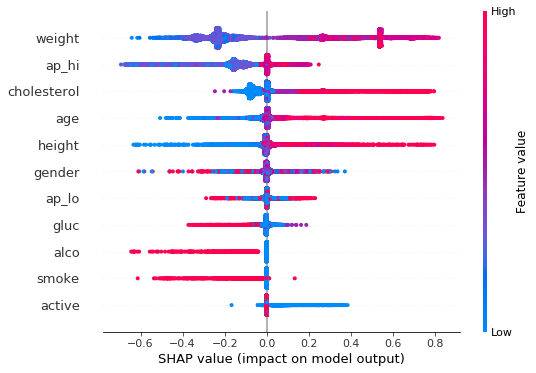

In [27]:
# plot the summary
plt.figure() 
shap.summary_plot(shap_values, under_over_x_train, show=False, feature_names=feature_names)
#plt.savefig('SHAP_Summary.png', bbox_inches="tight")
plt.show()